In [1]:
!pip install botorch
!pip install rdkit
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 481 kB 15.5 MB/s 
     |████████████████████████████████| 727 kB 71.2 MB/s 
     |████████████████████████████████| 245 kB 39.1 MB/s 
     |████████████████████████████████| 152 kB 55.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 29.3 MB 1.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 575 kB 13.7 MB/s 


In [2]:
import numpy as np
import pandas as pd
import rdkit
from rdkit import Chem, rdBase, DataStructs
from rdkit.Chem import rdmolfiles, rdmolops, AllChem, Draw, rdDepictor, Descriptors
from rdkit.Chem.Draw import IPythonConsole, rdMolDraw2D
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem.Fingerprints import FingerprintMols

from IPython.display import SVG
from IPython.display import HTML
from IPython.display import display

import torch
from botorch.models import SingleTaskGP
from gpytorch.kernels import ScaleKernel, RBFKernel, MaternKernel
from botorch.models.multitask import MultiTaskGP
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls import ExactMarginalLogLikelihood
from torch.optim import Adam
from collections import defaultdict
from tqdm import tqdm

#**Load Data**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
srims = pd.read_csv("./drive/MyDrive/AI/Material Informatics (MI)/Polymer Cloud Point QSAR/Binary Polymer Solution Cloud Point Data/Data/polymer_solvent_mixture_srims.csv")
srims.tail()

,Unnamed: 0,|M|n|||4|||elm|C-C-C.R,|M|n|||4|||elm|C-C.C-R,|M|n|||4|||elm|C.C-C-R,|M|n|||4|||elm|C.C-C-C,|M|n|||4|||elm|C-C.C-C,|M|n|||4|||elm|C.C-C=C,|M|n|||4|||elm|C-C.C=C,|S|n|||4|||elm|C-C(-C)-C,|S|n|||4|||elm|C(-C-R)-R,...,|S|n|||4|||elm|C=C-O.R,|S|n|||4|||elm|C-C.O-R,|S|n|||4|||elm|C-C=C-R,|S|n|||4|||elm|C=C-R.O,|M|n|||4|||elm|C(-O)-O.O,|S|n|||4|||elm|C.C(-O)-O,|S|n|||4|||elm|C-O.O-R,|S|n|||4|||elm|C(-O)-O.R,|S|n|||4|||elm|C-O-C-O,|S|n|||4|||elm|C(-O)-O-R
81,"('poly(alpha-methylstyrene)', 'trans-decahydro...",28,22,40,166,66,70,33,3,1,...,0,0,0,0,0,0,0,0,0,0
82,"('poly(alpha-methylstyrene)', 'cyclohexane')",12,12,24,78,36,42,18,1,1,...,0,0,0,0,0,0,0,0,0,0
83,"('poly(2-ethyl-2-oxazoline)', 'water')",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84,"('poly(2,6-dimethyl-1,4-phenylene oxide)', 'to...",2,4,7,22,20,112,27,0,0,...,1,4,1,1,0,0,0,0,0,0
85,"('poly(1,3-dioxolane)', 'water')",0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,1,1,1,1,1


In [5]:
srims = srims.rename(columns={"Unnamed: 0":"Combinations"})
srims

,Combinations,|M|n|||4|||elm|C-C-C.R,|M|n|||4|||elm|C-C.C-R,|M|n|||4|||elm|C.C-C-R,|M|n|||4|||elm|C.C-C-C,|M|n|||4|||elm|C-C.C-C,|M|n|||4|||elm|C.C-C=C,|M|n|||4|||elm|C-C.C=C,|S|n|||4|||elm|C-C(-C)-C,|S|n|||4|||elm|C(-C-R)-R,...,|S|n|||4|||elm|C=C-O.R,|S|n|||4|||elm|C-C.O-R,|S|n|||4|||elm|C-C=C-R,|S|n|||4|||elm|C=C-R.O,|M|n|||4|||elm|C(-O)-O.O,|S|n|||4|||elm|C.C(-O)-O,|S|n|||4|||elm|C-O.O-R,|S|n|||4|||elm|C(-O)-O.R,|S|n|||4|||elm|C-O-C-O,|S|n|||4|||elm|C(-O)-O-R
0,"('polystyrene', 'methylcyclohexane')",16,14,21,78,35,49,21,1,1,...,0,0,0,0,0,0,0,0,0,0
1,"('polystyrene', 'cyclohexanol')",12,12,18,60,30,42,18,0,1,...,0,0,0,0,0,0,0,0,0,0
2,"('polystyrene', 'methylcyclopentane')",14,12,18,68,30,42,18,1,1,...,0,0,0,0,0,0,0,0,0,0
3,"('polystyrene', 'nitroethane')",0,2,6,4,5,14,3,0,1,...,0,0,0,0,0,0,0,0,0,0
4,"('polystyrene', 'ethyl acetate')",0,4,12,8,10,28,6,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,"('poly(alpha-methylstyrene)', 'trans-decahydro...",28,22,40,166,66,70,33,3,1,...,0,0,0,0,0,0,0,0,0,0
82,"('poly(alpha-methylstyrene)', 'cyclohexane')",12,12,24,78,36,42,18,1,1,...,0,0,0,0,0,0,0,0,0,0
83,"('poly(2-ethyl-2-oxazoline)', 'water')",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84,"('poly(2,6-dimethyl-1,4-phenylene oxide)', 'to...",2,4,7,22,20,112,27,0,0,...,1,4,1,1,0,0,0,0,0,0


In [6]:
# srims.Combinations[0]

In [7]:
# srims.Combinations[0].split("'")

In [8]:
# srims.Combinations[1].split("'")[1]

In [9]:
df_original = pd.read_csv("./drive/MyDrive/AI/Material Informatics (MI)/Polymer Cloud Point QSAR/Binary Polymer Solution Cloud Point Data/Data/Binary Polymer Solution Cloud Point Database (d_dropped).csv")
df_original.head()

,Polymer,Polymer CAS,Polymer SMILES,Solvent,Solvent CAS,Solvent SMILES,Mw(Da),PDI,ϕ,w,P(Mpa),CP(°C),1-Phase,Ref.,Polymer Mols,Solvent Mols
0,polystyrene,9003-53-6,*C(C*)c1ccccc1,methylcyclohexane,108-87-2,CC1CCCCC1,17500,1.06,0.11406,0.15000,82.81,21.34,positive,doi.org/10.1002/macp.1994.021950233,<rdkit.Chem.rdchem.Mol object at 0x7f5ccfffa580>,<rdkit.Chem.rdchem.Mol object at 0x7f5ccff349e0>
1,polystyrene,9003-53-6,*C(C*)c1ccccc1,methylcyclohexane,108-87-2,CC1CCCCC1,17500,1.06,0.18196,0.23366,80.00,21.18,positive,doi.org/10.1002/macp.1994.021950233,<rdkit.Chem.rdchem.Mol object at 0x7f5ccfffa5f0>,<rdkit.Chem.rdchem.Mol object at 0x7f5ccff34a50>
2,polystyrene,9003-53-6,*C(C*)c1ccccc1,cyclohexanol,108-93-0,OC1CCCCC1,78800,1.12,0.00632,0.00700,0.10,73.99,positive,doi.org/10.1021/je0504865,<rdkit.Chem.rdchem.Mol object at 0x7f5ccfffa660>,<rdkit.Chem.rdchem.Mol object at 0x7f5ccff34ac0>
3,polystyrene,9003-53-6,*C(C*)c1ccccc1,methylcyclopentane,96-37-7,CC1CCCC1,22100,1.03,0.11401,0.15300,1.02,27.42,positive,doi.org/10.1021/ma00107a011,<rdkit.Chem.rdchem.Mol object at 0x7f5ccfffa6d0>,<rdkit.Chem.rdchem.Mol object at 0x7f5ccff34b30>
4,polystyrene,9003-53-6,*C(C*)c1ccccc1,nitroethane,79-24-3,CC[N+](=O)[O-],13500,1.06,0.17990,0.17990,4.35,6.08,positive,doi.org/10.1006/jcht.1999.0607,<rdkit.Chem.rdchem.Mol object at 0x7f5ccfffa740>,<rdkit.Chem.rdchem.Mol object at 0x7f5ccff34ba0>


In [10]:
add = df_original.loc[:, ["Polymer", "Solvent", "Mw(Da)", "PDI", "ϕ", "w", "P(Mpa)", "1-Phase", "CP(°C)"]]
print(add.shape)
add.head()

(4833, 9)


,Polymer,Solvent,Mw(Da),PDI,ϕ,w,P(Mpa),1-Phase,CP(°C)
0,polystyrene,methylcyclohexane,17500,1.06,0.11406,0.15000,82.81,positive,21.34
1,polystyrene,methylcyclohexane,17500,1.06,0.18196,0.23366,80.00,positive,21.18
2,polystyrene,cyclohexanol,78800,1.12,0.00632,0.00700,0.10,positive,73.99
3,polystyrene,methylcyclopentane,22100,1.03,0.11401,0.15300,1.02,positive,27.42
4,polystyrene,nitroethane,13500,1.06,0.17990,0.17990,4.35,positive,6.08


In [11]:
for idx in add.index:
  add.loc[idx, "Combinations"] = f"('{add.Polymer[idx]}', '{add.Solvent[idx]}')"
add

,Polymer,Solvent,Mw(Da),PDI,ϕ,w,P(Mpa),1-Phase,CP(°C),Combinations
0,polystyrene,methylcyclohexane,17500,1.06,0.11406,0.15000,82.81,positive,21.34,"('polystyrene', 'methylcyclohexane')"
1,polystyrene,methylcyclohexane,17500,1.06,0.18196,0.23366,80.00,positive,21.18,"('polystyrene', 'methylcyclohexane')"
2,polystyrene,cyclohexanol,78800,1.12,0.00632,0.00700,0.10,positive,73.99,"('polystyrene', 'cyclohexanol')"
3,polystyrene,methylcyclopentane,22100,1.03,0.11401,0.15300,1.02,positive,27.42,"('polystyrene', 'methylcyclopentane')"
4,polystyrene,nitroethane,13500,1.06,0.17990,0.17990,4.35,positive,6.08,"('polystyrene', 'nitroethane')"
...,...,...,...,...,...,...,...,...,...,...
4828,"poly(1,3-dioxolane)",water,50000,1.50,0.44220,0.50560,0.10,negative,63.14,"('poly(1,3-dioxolane)', 'water')"
4829,"poly(1,3-dioxolane)",water,50000,1.50,0.09225,0.11590,0.10,negative,71.08,"('poly(1,3-dioxolane)', 'water')"
4830,"poly(1,3-dioxolane)",water,50000,1.50,0.11156,0.13940,0.10,negative,72.63,"('poly(1,3-dioxolane)', 'water')"
4831,"poly(1,3-dioxolane)",water,50000,1.50,0.34850,0.40830,0.10,negative,73.50,"('poly(1,3-dioxolane)', 'water')"


In [12]:
df_com = pd.merge(srims, add, how="inner", on="Combinations")
#The position of the key for merge is based on first (left) dataset. So "Combinations" column is at first column.
print(df_com.shape)
df_com.head()

(4833, 322)


,Combinations,|M|n|||4|||elm|C-C-C.R,|M|n|||4|||elm|C-C.C-R,|M|n|||4|||elm|C.C-C-R,|M|n|||4|||elm|C.C-C-C,|M|n|||4|||elm|C-C.C-C,|M|n|||4|||elm|C.C-C=C,|M|n|||4|||elm|C-C.C=C,|S|n|||4|||elm|C-C(-C)-C,|S|n|||4|||elm|C(-C-R)-R,...,|S|n|||4|||elm|C(-O)-O-R,Polymer,Solvent,Mw(Da),PDI,ϕ,w,P(Mpa),1-Phase,CP(°C)
0,"('polystyrene', 'methylcyclohexane')",16,14,21,78,35,49,21,1,1,...,0,polystyrene,methylcyclohexane,17500,1.06,0.11406,0.15000,82.81,positive,21.34
1,"('polystyrene', 'methylcyclohexane')",16,14,21,78,35,49,21,1,1,...,0,polystyrene,methylcyclohexane,17500,1.06,0.18196,0.23366,80.00,positive,21.18
2,"('polystyrene', 'methylcyclohexane')",16,14,21,78,35,49,21,1,1,...,0,polystyrene,methylcyclohexane,405000,2.83,0.01836,0.02500,4.09,positive,56.35
3,"('polystyrene', 'methylcyclohexane')",16,14,21,78,35,49,21,1,1,...,0,polystyrene,methylcyclohexane,16100,1.06,0.09728,0.12870,51.68,positive,19.63
4,"('polystyrene', 'methylcyclohexane')",16,14,21,78,35,49,21,1,1,...,0,polystyrene,methylcyclohexane,297000,5.45,0.04374,0.05900,0.10,positive,57.82


In [13]:
#Drop Polymer and Solvent  columns
df_com = df_com.drop(["Polymer", "Solvent"], axis=1)
print(df_com.shape)
df_com.head()

(4833, 320)


,Combinations,|M|n|||4|||elm|C-C-C.R,|M|n|||4|||elm|C-C.C-R,|M|n|||4|||elm|C.C-C-R,|M|n|||4|||elm|C.C-C-C,|M|n|||4|||elm|C-C.C-C,|M|n|||4|||elm|C.C-C=C,|M|n|||4|||elm|C-C.C=C,|S|n|||4|||elm|C-C(-C)-C,|S|n|||4|||elm|C(-C-R)-R,...,|S|n|||4|||elm|C(-O)-O.R,|S|n|||4|||elm|C-O-C-O,|S|n|||4|||elm|C(-O)-O-R,Mw(Da),PDI,ϕ,w,P(Mpa),1-Phase,CP(°C)
0,"('polystyrene', 'methylcyclohexane')",16,14,21,78,35,49,21,1,1,...,0,0,0,17500,1.06,0.11406,0.15000,82.81,positive,21.34
1,"('polystyrene', 'methylcyclohexane')",16,14,21,78,35,49,21,1,1,...,0,0,0,17500,1.06,0.18196,0.23366,80.00,positive,21.18
2,"('polystyrene', 'methylcyclohexane')",16,14,21,78,35,49,21,1,1,...,0,0,0,405000,2.83,0.01836,0.02500,4.09,positive,56.35
3,"('polystyrene', 'methylcyclohexane')",16,14,21,78,35,49,21,1,1,...,0,0,0,16100,1.06,0.09728,0.12870,51.68,positive,19.63
4,"('polystyrene', 'methylcyclohexane')",16,14,21,78,35,49,21,1,1,...,0,0,0,297000,5.45,0.04374,0.05900,0.10,positive,57.82


In [14]:
#For 1-Phase, use LabelEncoder to transfer str to int.
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
LE.fit_transform(df_com["1-Phase"])

df_com["1-Phase"] = LE.fit_transform(df_com["1-Phase"])
df_com.head()

,Combinations,|M|n|||4|||elm|C-C-C.R,|M|n|||4|||elm|C-C.C-R,|M|n|||4|||elm|C.C-C-R,|M|n|||4|||elm|C.C-C-C,|M|n|||4|||elm|C-C.C-C,|M|n|||4|||elm|C.C-C=C,|M|n|||4|||elm|C-C.C=C,|S|n|||4|||elm|C-C(-C)-C,|S|n|||4|||elm|C(-C-R)-R,...,|S|n|||4|||elm|C(-O)-O.R,|S|n|||4|||elm|C-O-C-O,|S|n|||4|||elm|C(-O)-O-R,Mw(Da),PDI,ϕ,w,P(Mpa),1-Phase,CP(°C)
0,"('polystyrene', 'methylcyclohexane')",16,14,21,78,35,49,21,1,1,...,0,0,0,17500,1.06,0.11406,0.15000,82.81,1,21.34
1,"('polystyrene', 'methylcyclohexane')",16,14,21,78,35,49,21,1,1,...,0,0,0,17500,1.06,0.18196,0.23366,80.00,1,21.18
2,"('polystyrene', 'methylcyclohexane')",16,14,21,78,35,49,21,1,1,...,0,0,0,405000,2.83,0.01836,0.02500,4.09,1,56.35
3,"('polystyrene', 'methylcyclohexane')",16,14,21,78,35,49,21,1,1,...,0,0,0,16100,1.06,0.09728,0.12870,51.68,1,19.63
4,"('polystyrene', 'methylcyclohexane')",16,14,21,78,35,49,21,1,1,...,0,0,0,297000,5.45,0.04374,0.05900,0.10,1,57.82


In [15]:
f_phase0 = df_com[df_com["1-Phase"]==0]
f_phase0_d = f_phase0.drop(["1-Phase", "Combinations"], axis=1)
f_phase1 = df_com[df_com["1-Phase"]==1]
f_phase1_d = f_phase1.drop(["1-Phase", "Combinations"], axis=1)

# **Model Building**

In [16]:
from sklearn.model_selection import train_test_split

X_0 = f_phase0_d.iloc[:, :-1].values
y_0 = f_phase0_d.iloc[:, -1].values
X_1 = f_phase1_d.iloc[:, :-1].values
y_1 = f_phase1_d.iloc[:, -1].values

#Feature scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_0_std = sc.fit_transform(X_0)
X_1_std = sc.fit_transform(X_1)

#Seperating literature data to training and validation data
X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split(X_0_std, y_0, test_size=0.2, random_state=5)
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1_std, y_1, test_size=0.2, random_state=5)

In [17]:
# A list for the evaluation result
rmse_sum_0 = {}
rmse_sum_1 = {}
r2_sum_0 = {}
r2_sum_1 = {}

## Lasso

In [18]:
from sklearn.linear_model import Lasso

lasso_0 = Lasso(alpha=0.1)
lasso_1 = Lasso(alpha=0.1)

lasso_0.fit(X_train_0, y_train_0)
lasso_1.fit(X_train_1, y_train_1)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.622e+03, tolerance: 7.607e+02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.891e+03, tolerance: 4.298e+02
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=0.1)

In [19]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

R_square_train_0 = r2_score(y_train_0, lasso_0.predict(X_train_0))
RMSE_train_0 = mean_squared_error(y_train_0, lasso_0.predict(X_train_0), squared=False)
R_square_test_0 = r2_score(y_test_0, lasso_0.predict(X_test_0))
RMSE_test_0 = mean_squared_error(y_test_0, lasso_0.predict(X_test_0), squared=False)

print(f'R_square(Train_0): {R_square_train_0}\nRMSE(Train_0): {RMSE_train_0}')
print(f'R_square(Test_0): {R_square_test_0}\nRMSE(Test_0): {RMSE_test_0}\n')

R_square_train_1 = r2_score(y_train_1, lasso_1.predict(X_train_1))
RMSE_train_1 = mean_squared_error(y_train_1, lasso_1.predict(X_train_1), squared=False)
R_square_test_1 = r2_score(y_test_1, lasso_1.predict(X_test_1))
RMSE_test_1 = mean_squared_error(y_test_1, lasso_1.predict(X_test_1), squared=False)

print(f'R_square(Train_1): {R_square_train_1}\nRMSE(Train_1): {RMSE_train_1}')
print(f'R_square(Test_1): {R_square_test_1}\nRMSE(Test_1): {RMSE_test_1}')

R_square(Train_0): 0.9533241963517886
RMSE(Train_0): 15.551944130344076
R_square(Test_0): 0.9556641830630447
RMSE(Test_0): 14.962952008644203

R_square(Train_1): 0.8104781793622665
RMSE(Train_1): 18.435411610084728
R_square(Test_1): 0.8272590602918849
RMSE(Test_1): 18.273937501447158


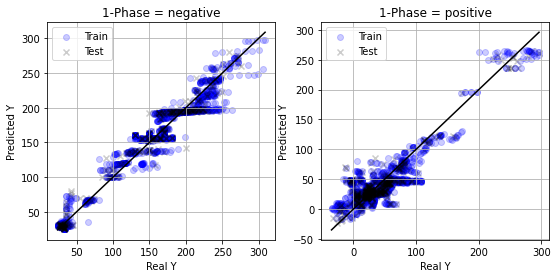

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(9,4))

ax1 = fig.add_subplot(1, 2, 1)
ax1.scatter(y_train_0, lasso_0.predict(X_train_0), alpha=0.2, c="blue", label='Train')
ax1.scatter(y_test_0, lasso_0.predict(X_test_0), alpha=0.2, c="black", marker='x', label='Test')
ax1.plot([y_train_0.min(), y_train_0.max()], [y_train_0.min(), y_train_0.max()], c="black")
ax1.legend()
ax1.grid()
ax1.set_xlabel("Real Y")
ax1.set_ylabel("Predicted Y")
ax1.set_title("1-Phase = negative")

ax2 = fig.add_subplot(1, 2, 2)
ax2.scatter(y_train_1, lasso_1.predict(X_train_1), alpha=0.2, c="blue", label='Train')
ax2.scatter(y_test_1, lasso_1.predict(X_test_1), alpha=0.2, c="black", marker='x', label='Test')
ax2.plot([y_train_1.min(), y_train_1.max()], [y_train_1.min(), y_train_1.max()], c="black")
ax2.legend()
ax2.grid()
ax2.set_xlabel("Real Y")
ax2.set_ylabel("Predicted Y")
ax2.set_title("1-Phase = positive")

fig.show()

In [21]:
rmse_sum_0['Linear Regression(Lasso)'] = [RMSE_train_0, RMSE_test_0] 
r2_sum_0['Linear Regression(Lasso)'] = [R_square_train_0, R_square_test_0] 
rmse_sum_1['Linear Regression(Lasso)'] = [RMSE_train_1, RMSE_test_1] 
r2_sum_1['Linear Regression(Lasso)'] = [R_square_train_1, R_square_test_1] 

## Ridge

In [22]:
from sklearn.linear_model import Ridge
ridge_0 = Ridge(alpha=0.1)
ridge_1 = Ridge(alpha=0.1)

ridge_0.fit(X_train_0, y_train_0)
ridge_1.fit(X_train_1, y_train_1)

Ridge(alpha=0.1)

In [23]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

R_square_train_0 = r2_score(y_train_0, ridge_0.predict(X_train_0))
RMSE_train_0 = mean_squared_error(y_train_0, ridge_0.predict(X_train_0), squared=False)
R_square_test_0 = r2_score(y_test_0, ridge_0.predict(X_test_0))
RMSE_test_0 = mean_squared_error(y_test_0, ridge_0.predict(X_test_0), squared=False)

print(f'R_square(Train_0): {R_square_train_0}\nRMSE(Train_0): {RMSE_train_0}')
print(f'R_square(Test_0): {R_square_test_0}\nRMSE(Test_0): {RMSE_test_0}\n')

R_square_train_1 = r2_score(y_train_1, ridge_1.predict(X_train_1))
RMSE_train_1 = mean_squared_error(y_train_1, ridge_1.predict(X_train_1), squared=False)
R_square_test_1 = r2_score(y_test_1, ridge_1.predict(X_test_1))
RMSE_test_1 = mean_squared_error(y_test_1, ridge_1.predict(X_test_1), squared=False)

print(f'R_square(Train_1): {R_square_train_1}\nRMSE(Train_1): {RMSE_train_1}')
print(f'R_square(Test_1): {R_square_test_1}\nRMSE(Test_1): {RMSE_test_1}')

R_square(Train_0): 0.9584054799279236
RMSE(Train_0): 14.681040749670867
R_square(Test_0): 0.9587152798979288
RMSE(Test_0): 14.438916259959049

R_square(Train_1): 0.8342816981203564
RMSE(Train_1): 17.23885695298374
R_square(Test_1): 0.8479914861687041
RMSE(Test_1): 17.142274801322042


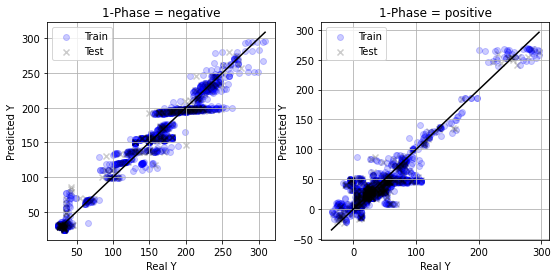

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(9,4))

ax1 = fig.add_subplot(1, 2, 1)
ax1.scatter(y_train_0, ridge_0.predict(X_train_0), alpha=0.2, c="blue", label='Train')
ax1.scatter(y_test_0, ridge_0.predict(X_test_0), alpha=0.2, c="black", marker='x', label='Test')
ax1.plot([y_train_0.min(), y_train_0.max()], [y_train_0.min(), y_train_0.max()], c="black")
ax1.legend()
ax1.grid()
ax1.set_xlabel("Real Y")
ax1.set_ylabel("Predicted Y")
ax1.set_title("1-Phase = negative")

ax2 = fig.add_subplot(1, 2, 2)
ax2.scatter(y_train_1, ridge_1.predict(X_train_1), alpha=0.2, c="blue", label='Train')
ax2.scatter(y_test_1, ridge_1.predict(X_test_1), alpha=0.2, c="black", marker='x', label='Test')
ax2.plot([y_train_1.min(), y_train_1.max()], [y_train_1.min(), y_train_1.max()], c="black")
ax2.legend()
ax2.grid()
ax2.set_xlabel("Real Y")
ax2.set_ylabel("Predicted Y")
ax2.set_title("1-Phase = positive")

fig.show()

In [25]:
rmse_sum_0['Linear Regression(Ridge)'] = [RMSE_train_0, RMSE_test_0] 
r2_sum_0['Linear Regression(Ridge)'] = [R_square_train_0, R_square_test_0] 
rmse_sum_1['Linear Regression(Ridge)'] = [RMSE_train_1, RMSE_test_1] 
r2_sum_1['Linear Regression(Ridge)'] = [R_square_train_1, R_square_test_1] 

## ElasticNet

In [26]:
from sklearn.linear_model import ElasticNet
EN_0 = ElasticNet(alpha=0.1)
EN_1 = ElasticNet(alpha=0.1)

EN_0.fit(X_train_0, y_train_0)
EN_1.fit(X_train_1, y_train_1)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.439e+04, tolerance: 7.607e+02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.823e+03, tolerance: 4.298e+02
  model = cd_fast.enet_coordinate_descent(


ElasticNet(alpha=0.1)

In [27]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

R_square_train_0 = r2_score(y_train_0, EN_0.predict(X_train_0))
RMSE_train_0 = mean_squared_error(y_train_0, EN_0.predict(X_train_0), squared=False)
R_square_test_0 = r2_score(y_test_0, EN_0.predict(X_test_0))
RMSE_test_0 = mean_squared_error(y_test_0, EN_0.predict(X_test_0), squared=False)

print(f'R_square(Train_0): {R_square_train_0}\nRMSE(Train_0): {RMSE_train_0}')
print(f'R_square(Test_0): {R_square_test_0}\nRMSE(Test_0): {RMSE_test_0}\n')

R_square_train_1 = r2_score(y_train_1, EN_1.predict(X_train_1))
RMSE_train_1 = mean_squared_error(y_train_1, EN_1.predict(X_train_1), squared=False)
R_square_test_1 = r2_score(y_test_1, EN_1.predict(X_test_1))
RMSE_test_1 = mean_squared_error(y_test_1, EN_1.predict(X_test_1), squared=False)

print(f'R_square(Train_1): {R_square_train_1}\nRMSE(Train_1): {RMSE_train_1}')
print(f'R_square(Test_1): {R_square_test_1}\nRMSE(Test_1): {RMSE_test_1}')

R_square(Train_0): 0.9465077553781585
RMSE(Train_0): 16.64884830524933
R_square(Test_0): 0.9499491057034812
RMSE(Test_0): 15.898122764553392

R_square(Train_1): 0.7875974491170771
RMSE(Train_1): 19.516551988355783
R_square(Test_1): 0.8107968704939669
RMSE(Test_1): 19.12487715012902


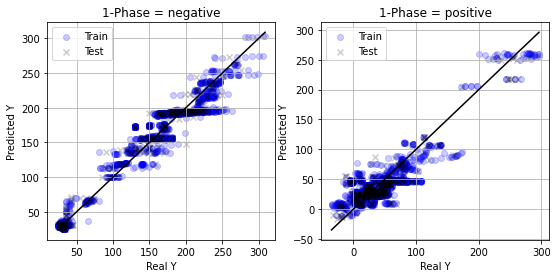

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(9,4))

ax1 = fig.add_subplot(1, 2, 1)
ax1.scatter(y_train_0, EN_0.predict(X_train_0), alpha=0.2, c="blue", label='Train')
ax1.scatter(y_test_0, EN_0.predict(X_test_0), alpha=0.2, c="black", marker='x', label='Test')
ax1.plot([y_train_0.min(), y_train_0.max()], [y_train_0.min(), y_train_0.max()], c="black")
ax1.legend()
ax1.grid()
ax1.set_xlabel("Real Y")
ax1.set_ylabel("Predicted Y")
ax1.set_title("1-Phase = negative")

ax2 = fig.add_subplot(1, 2, 2)
ax2.scatter(y_train_1, EN_1.predict(X_train_1), alpha=0.2, c="blue", label='Train')
ax2.scatter(y_test_1, EN_1.predict(X_test_1), alpha=0.2, c="black", marker='x', label='Test')
ax2.plot([y_train_1.min(), y_train_1.max()], [y_train_1.min(), y_train_1.max()], c="black")
ax2.legend()
ax2.grid()
ax2.set_xlabel("Real Y")
ax2.set_ylabel("Predicted Y")
ax2.set_title("1-Phase = positive")

fig.show()

In [29]:
rmse_sum_0['Linear Regression(ElasticNet)'] = [RMSE_train_0, RMSE_test_0] 
r2_sum_0['Linear Regression(ElasticNet)'] = [R_square_train_0, R_square_test_0] 
rmse_sum_1['Linear Regression(ElasticNet)'] = [RMSE_train_1, RMSE_test_1] 
r2_sum_1['Linear Regression(ElasticNet)'] = [R_square_train_1, R_square_test_1] 

## RF

In [30]:
from sklearn.ensemble import RandomForestRegressor
rf_0 = RandomForestRegressor()
rf_1 = RandomForestRegressor()

rf_0.fit(X_train_0, y_train_0)
rf_1.fit(X_train_1, y_train_1)

RandomForestRegressor()

In [31]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

print("For 1-Phase = negative")
R_square_train_0 = r2_score(y_train_0, rf_0.predict(X_train_0))
RMSE_train_0 = mean_squared_error(y_train_0, rf_0.predict(X_train_0), squared=False)
R_square_test_0 = r2_score(y_test_0, rf_0.predict(X_test_0))
RMSE_test_0 = mean_squared_error(y_test_0, rf_0.predict(X_test_0), squared=False)

print(f'R_square(Train): {R_square_train_0}\nRMSE(Train): {RMSE_train_0}')
print(f'R_square(Test): {R_square_test_0}\nRMSE(Test): {RMSE_test_0}\n')

print("For 1-Phase = positive")
R_square_train_1 = r2_score(y_train_1, rf_1.predict(X_train_1))
RMSE_train_1 = mean_squared_error(y_train_1, rf_1.predict(X_train_1), squared=False)
R_square_test_1 = r2_score(y_test_1, rf_1.predict(X_test_1))
RMSE_test_1 = mean_squared_error(y_test_1, rf_1.predict(X_test_1), squared=False)

print(f'R_square(Train): {R_square_train_1}\nRMSE(Train): {RMSE_train_1}')
print(f'R_square(Test): {R_square_test_1}\nRMSE(Test): {RMSE_test_1}')

For 1-Phase = negative
R_square(Train): 0.9993978829351203
RMSE(Train): 1.7663601296710736
R_square(Test): 0.9966121473675846
RMSE(Test): 4.136206195304789

For 1-Phase = positive
R_square(Train): 0.9987649561079226
RMSE(Train): 1.4882107071990358
R_square(Test): 0.9924813184934371
RMSE(Test): 3.8124603926699234


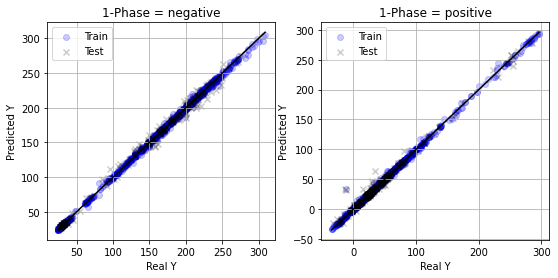

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(9,4))

ax1 = fig.add_subplot(1, 2, 1)
ax1.scatter(y_train_0, rf_0.predict(X_train_0), alpha=0.2, c="blue", label='Train')
ax1.scatter(y_test_0, rf_0.predict(X_test_0), alpha=0.2, c="black", marker='x', label='Test')
ax1.plot([y_train_0.min(), y_train_0.max()], [y_train_0.min(), y_train_0.max()], c="black")
ax1.legend()
ax1.grid()
ax1.set_xlabel("Real Y")
ax1.set_ylabel("Predicted Y")
ax1.set_title("1-Phase = negative")

ax2 = fig.add_subplot(1, 2, 2)
ax2.scatter(y_train_1, rf_1.predict(X_train_1), alpha=0.2, c="blue", label='Train')
ax2.scatter(y_test_1, rf_1.predict(X_test_1), alpha=0.2, c="black", marker='x', label='Test')
ax2.plot([y_train_1.min(), y_train_1.max()], [y_train_1.min(), y_train_1.max()], c="black")
ax2.legend()
ax2.grid()
ax2.set_xlabel("Real Y")
ax2.set_ylabel("Predicted Y")
ax2.set_title("1-Phase = positive")

fig.show()

In [33]:
rmse_sum_0['RF'] = [RMSE_train_0, RMSE_test_0] 
r2_sum_0['RF'] = [R_square_train_0, R_square_test_0] 
rmse_sum_1['RF'] = [RMSE_train_1, RMSE_test_1] 
r2_sum_1['RF'] = [R_square_train_1, R_square_test_1] 

## SVR

In [34]:
# from sklearn.svm import SVR
# svr = SVR()
# svr.fit(X_train, y_train)

In [35]:
# from sklearn.metrics import r2_score
# from sklearn.metrics import mean_squared_error

# R_square_train = r2_score(y_train, svr.predict(X_train))
# RMSE_train = mean_squared_error(y_train, svr.predict(X_train), squared=False)
# R_square_test = r2_score(y_test, svr.predict(X_test))
# RMSE_test = mean_squared_error(y_test, svr.predict(X_test), squared=False)

# print(f'R_square(Train): {R_square_train}\nRMSE(Train): {RMSE_train}\n')
# print(f'R_square(Test): {R_square_test}\nRMSE(Test): {RMSE_test}')

In [36]:
# %matplotlib inline
# import matplotlib.pyplot as plt
# plt.figure(figsize=(4,4))
# plt.scatter(y_train, svr.predict(X_train), alpha=0.2, c="blue", label='Train')
# plt.scatter(y_test, svr.predict(X_test), alpha=0.2, c="black", marker='x', label='Test')
# plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], c="black")
# plt.legend()
# plt.grid()
# plt.xlabel("Real Y")
# plt.ylabel("Predicted Y")
# plt.show()

In [37]:
# rmse_sum['SVR'] = [RMSE_train, RMSE_test] 
# r2_sum['SVR'] = [R_square_train, R_square_test] 

## XGB

In [38]:
# import xgboost as xgb
# xgb_reg = xgb.XGBRegressor()
# params = {'metric':'rmse',
#           'objective':'reg:squarederror',
#           'n_estimators':5000,
#           'booster': 'gbtree',
#           'learning_rate':0.01,
#           'min_child_weight':1,
#           'max_depth':5,
#           'random_state':0,
#           'colsample_bytree':1,
#           'subsample':1,
#          }
# xgb_reg.set_params(**params)
# xgb_reg.fit(X_train, y_train)

In [39]:
# from sklearn.metrics import r2_score
# from sklearn.metrics import mean_squared_error

# R_square_train = r2_score(y_train, xgb_reg.predict(X_train))
# RMSE_train = mean_squared_error(y_train, xgb_reg.predict(X_train), squared=False)
# R_square_test = r2_score(y_test, xgb_reg.predict(X_test))
# RMSE_test = mean_squared_error(y_test, xgb_reg.predict(X_test), squared=False)

# print(f'R_square(Train): {R_square_train}\nRMSE(Train): {RMSE_train}\n')
# print(f'R_square(Test): {R_square_test}\nRMSE(Test): {RMSE_test}')

In [40]:
# %matplotlib inline
# import matplotlib.pyplot as plt
# plt.figure(figsize=(4,4))
# plt.scatter(y_train, xgb_reg.predict(X_train), alpha=0.2, c="blue", label='Train')
# plt.scatter(y_test, xgb_reg.predict(X_test), alpha=0.2, c="black", marker='x', label='Test')
# plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], c="black")
# plt.legend()
# plt.grid()
# plt.xlabel("Real Y")
# plt.ylabel("Predicted Y")
# plt.show()

In [41]:
# rmse_sum['XGBoost'] = [RMSE_train, RMSE_test] 
# r2_sum['XGBoost'] = [R_square_train, R_square_test] 

## GpyTorch

In [46]:
from sklearn.model_selection import train_test_split

X_0 = f_phase0_d.iloc[:, :-1].values
y_0 = f_phase0_d.iloc[:, -1].values
X_1 = f_phase1_d.iloc[:, :-1].values
y_1 = f_phase1_d.iloc[:, -1].values

#Seperating literature data to training and validation data
X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split(X_0, y_0, test_size=0.2, random_state=5)
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size=0.2, random_state=5)

In [47]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler

# X must be in the range=(0, 1)
# use MinMaxScaler to transform features
mmscaler = MinMaxScaler()
X_train_mm_0 = mmscaler.fit_transform(X_train_0)
X_test_mm_0 = mmscaler.transform(X_test_0)
X_train_mm_1 = mmscaler.fit_transform(X_train_1)
X_test_mm_1 = mmscaler.transform(X_test_1)

X_train_tensor_0 = torch.from_numpy(np.array(X_train_mm_0))
X_test_tensor_0 = torch.from_numpy(np.array(X_test_mm_0))
X_train_tensor_1 = torch.from_numpy(np.array(X_train_mm_1))
X_test_tensor_1 = torch.from_numpy(np.array(X_test_mm_1))

# Y must be in the range=(-1, 1)
y_scaler = StandardScaler()

y_train_s_0 = y_scaler.fit_transform(y_train_0.reshape(-1, 1))
y_test_s_0 = y_scaler.transform(y_test_0.reshape(-1, 1))
y_train_s_1 = y_scaler.fit_transform(y_train_1.reshape(-1, 1))
y_test_s_1 = y_scaler.transform(y_test_1.reshape(-1, 1))

y_train_tensor_0 = torch.from_numpy(np.array(y_train_s_0))
y_test_tensor_0 = torch.from_numpy(np.array(y_test_s_0))
y_train_tensor_1 = torch.from_numpy(np.array(y_train_s_1))
y_test_tensor_1 = torch.from_numpy(np.array(y_test_s_1))

In [48]:
kernel_0 = RBFKernel(ard_num_dims=X_0.shape[1])

gp_0 = SingleTaskGP(X_train_tensor_0, y_train_tensor_0, covar_module=kernel_0)
mll_0 = ExactMarginalLogLikelihood(gp_0.likelihood, gp_0)

fit_gpytorch_model(mll_0)

ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): RBFKernel(
      (raw_lengthscale_constraint): Positive()
      (distance_module): Distance()
    )
  )
)

In [49]:
kernel_1 = RBFKernel(ard_num_dims=X_1.shape[1])

gp_1 = SingleTaskGP(X_train_tensor_1, y_train_tensor_1, covar_module=kernel_1)
mll_1 = ExactMarginalLogLikelihood(gp_1.likelihood, gp_1)

fit_gpytorch_model(mll_1)

ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): RBFKernel(
      (raw_lengthscale_constraint): Positive()
      (distance_module): Distance()
    )
  )
)

In [50]:
# import pickle

# with open('./drive/MyDrive/AI/Material Informatics (MI)/Polymer Cloud Point QSAR/Binary Polymer Solution Cloud Point Data/Trained_model/gp_test.pkl', mode='wb') as f:
#   pickle.dump(gp,f)

In [51]:
# import pickle
# with open('./drive/MyDrive/AI/Material Informatics (MI)/Polymer Cloud Point QSAR/Binary Polymer Solution Cloud Point Data/Trained_model/gp_test.pkl', mode='rb') as m:
#   gp = pickle.load(m)

In [52]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

y_train_pred_0 = gp_0.posterior(X_train_tensor_0).mean.detach().numpy().copy()
y_train_var_0 = gp_0.posterior(X_train_tensor_0).variance.detach().numpy().copy()
y_train_pred_1 = gp_1.posterior(X_train_tensor_1).mean.detach().numpy().copy()
y_train_var_1 = gp_1.posterior(X_train_tensor_1).variance.detach().numpy().copy()

y_test_pred_0 = gp_0.posterior(X_test_tensor_0).mean.detach().numpy().copy()
y_test_var_0 = gp_0.posterior(X_test_tensor_0).variance.detach().numpy().copy()
y_test_pred_1 = gp_1.posterior(X_test_tensor_1).mean.detach().numpy().copy()
y_test_var_1 = gp_1.posterior(X_test_tensor_1).variance.detach().numpy().copy()

print("For 1-Phase = negative")
R_square_train_0 = r2_score(y_train_s_0, y_train_pred_0)
RMSE_train_0 = mean_squared_error(y_scaler.inverse_transform(y_train_s_0), y_scaler.inverse_transform(y_train_pred_0), squared=False)
R_square_test_0 = r2_score(y_test_s_0, y_test_pred_0)
RMSE_test_0 = mean_squared_error(y_scaler.inverse_transform(y_test_s_0), y_scaler.inverse_transform(y_test_pred_0), squared=False)

print(f'R_square(Train): {R_square_train_0}\nRMSE(Train): {RMSE_train_0}')
print(f'R_square(Test): {R_square_test_0}\nRMSE(Test): {RMSE_test_0}\n')

print("For 1-Phase = positive")
R_square_train_1 = r2_score(y_train_s_1, y_train_pred_1)
RMSE_train_1 = mean_squared_error(y_scaler.inverse_transform(y_train_s_1), y_scaler.inverse_transform(y_train_pred_1), squared=False)
R_square_test_1 = r2_score(y_test_s_1, y_test_pred_1)
RMSE_test_1 = mean_squared_error(y_scaler.inverse_transform(y_test_s_1), y_scaler.inverse_transform(y_test_pred_1), squared=False)

print(f'R_square(Train): {R_square_train_1}\nRMSE(Train): {RMSE_train_1}')
print(f'R_square(Test): {R_square_test_1}\nRMSE(Test): {RMSE_test_1}\n')

For 1-Phase = negative
R_square(Train): 0.9912664579256385
RMSE(Train): 3.957477342768677
R_square(Test): 0.9885780352691226
RMSE(Test): 4.467810826835398

For 1-Phase = positive
R_square(Train): 0.8772844800031205
RMSE(Train): 14.83450211130295
R_square(Test): 0.8841361387268025
RMSE(Test): 14.966094914561442



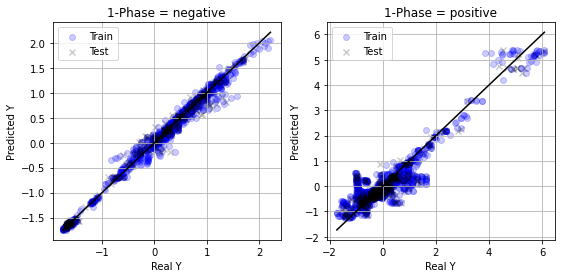

In [53]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(9,4))

ax1 = fig.add_subplot(1, 2, 1)
ax1.scatter(y_train_s_0, y_train_pred_0, alpha=0.2, c="blue", label='Train')
ax1.scatter(y_test_s_0, y_test_pred_0, alpha=0.2, c="black", marker='x', label='Test')
ax1.plot([y_train_s_0.min(), y_train_s_0.max()], [y_train_s_0.min(), y_train_s_0.max()], c="black")
ax1.legend()
ax1.grid()
ax1.set_xlabel("Real Y")
ax1.set_ylabel("Predicted Y")
ax1.set_title("1-Phase = negative")

ax2 = fig.add_subplot(1, 2, 2)
ax2.scatter(y_train_s_1, y_train_pred_1, alpha=0.2, c="blue", label='Train')
ax2.scatter(y_test_s_1, y_test_pred_1, alpha=0.2, c="black", marker='x', label='Test')
ax2.plot([y_train_s_1.min(), y_train_s_1.max()], [y_train_s_1.min(), y_train_s_1.max()], c="black")
ax2.legend()
ax2.grid()
ax2.set_xlabel("Real Y")
ax2.set_ylabel("Predicted Y")
ax2.set_title("1-Phase = positive")

fig.show()

In [54]:
rmse_sum_0['GP'] = [RMSE_train_0, RMSE_test_0] 
r2_sum_0['GP'] = [R_square_train_0, R_square_test_0] 
rmse_sum_1['GP'] = [RMSE_train_1, RMSE_test_1] 
r2_sum_1['GP'] = [R_square_train_1, R_square_test_1] 

# **Summary**

In [55]:
summary = pd.concat([pd.DataFrame(r2_sum_0, index=['Train (R square)', 'Test (R square)']), pd.DataFrame(rmse_sum_0, index=['Train (RMSE)', 'Test (RMSE)'])])
summary.style.set_caption("1-Phase = negative")

,Linear Regression(Lasso),Linear Regression(Ridge),Linear Regression(ElasticNet),RF,GP
Train (R square),0.953324,0.958405,0.946508,0.999398,0.991266
Test (R square),0.955664,0.958715,0.949949,0.996612,0.988578
Train (RMSE),15.551944,14.681041,16.648848,1.766360,3.957477
Test (RMSE),14.962952,14.438916,15.898123,4.136206,4.467811


In [56]:
summary = pd.concat([pd.DataFrame(r2_sum_1, index=['Train (R square)', 'Test (R square)']), pd.DataFrame(rmse_sum_1, index=['Train (RMSE)', 'Test (RMSE)'])])
summary.style.set_caption("1-Phase = positive")

,Linear Regression(Lasso),Linear Regression(Ridge),Linear Regression(ElasticNet),RF,GP
Train (R square),0.810478,0.834282,0.787597,0.998765,0.877284
Test (R square),0.827259,0.847991,0.810797,0.992481,0.884136
Train (RMSE),18.435412,17.238857,19.516552,1.488211,14.834502
Test (RMSE),18.273938,17.142275,19.124877,3.812460,14.966095


# **Feature Importance**

1-Phase = negative

Text(0.5, 0, 'Feature Importance')

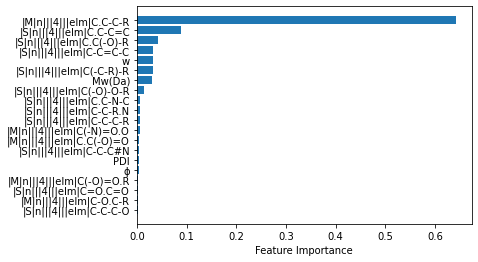

In [57]:
import matplotlib.pyplot as plt

sort = rf_0.feature_importances_.argsort()
plt.barh(f_phase0.columns[sort].astype(str)[-20:], rf_0.feature_importances_[sort][-20:])
plt.xlabel("Feature Importance")

model_output = "margin" has been renamed to model_output = "raw"


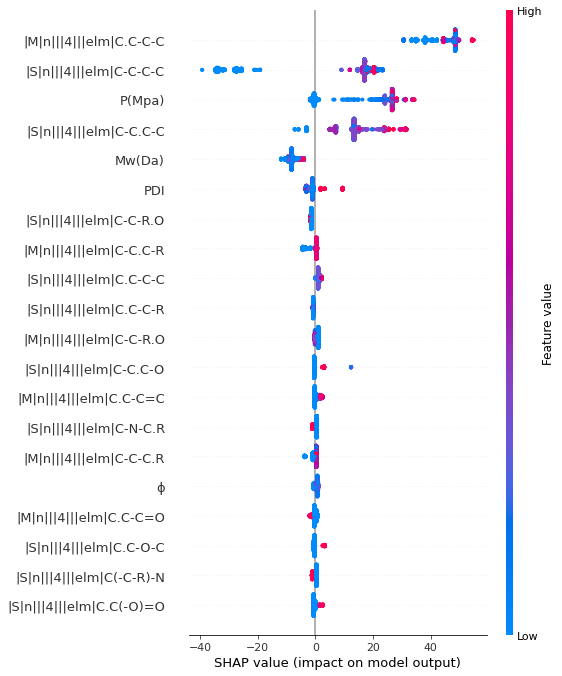

In [59]:
import shap

shap.initjs()
explainer = shap.TreeExplainer(model=rf_0, feature_perturbation='tree_path_dependent', model_output='margin')
shap_values = explainer.shap_values(X=f_phase0_d)
shap.summary_plot(shap_values, f_phase0_d)

1-Phase = positive

Text(0.5, 0, 'Feature Importance')

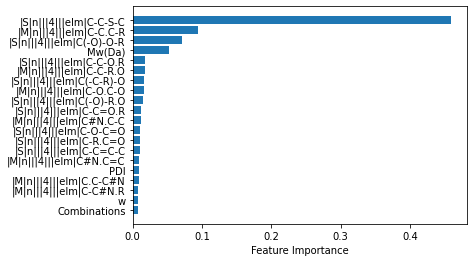

In [60]:
import matplotlib.pyplot as plt

sort = rf_1.feature_importances_.argsort()
plt.barh(f_phase1.columns[sort].astype(str)[-20:], rf_1.feature_importances_[sort][-20:])
plt.xlabel("Feature Importance")

model_output = "margin" has been renamed to model_output = "raw"


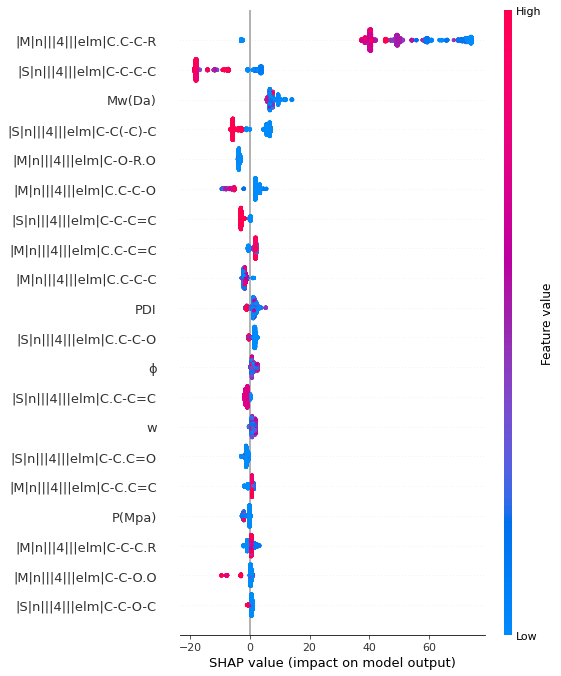

In [61]:
import shap

shap.initjs()
explainer = shap.TreeExplainer(model=rf_1, feature_perturbation='tree_path_dependent', model_output='margin')
shap_values = explainer.shap_values(X=f_phase1_d)
shap.summary_plot(shap_values, f_phase1_d)

Shap of GP(未完成)

In [ ]:
class model_for_shap:
  
  def __init__(self, model):
    self.model = model
    return

  def predict(self, X):
    X_tensor = torch.from_numpy(np.array(X))
    return self.model.posterior(X_tensor).mean.detach().numpy().copy()

1-Phase = negative

In [ ]:
import shap

gp_shap = model_for_shap(gp_0)
explainer = shap.KernelExplainer(gp_shap.predict, X_train_0)
shap_values = explainer.shap_values(X_train_0)[0]


In [ ]:
shap.summary_plot(shap_values, X_train_0)